# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Ridge and Lasso) to predict house prices.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: ROC/ AUC curves, accuracy, precision, F1-score, R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Determine the best regression model for price prediction.
- Convert categorical data to numerical data.
- Evaluate the effect of scaling/ normalization on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## Planning

1. Input data
2. Fitting models - linear, lasso, ridge
3. Evaluating models
4. K-fold cross evaluation
5. Hyperparameter tuning
6. Pipeline for best model
7. More advanced things - scaling, categorical -> numeric, other metrics, PCA

## 1. Input data

Make train-test splits of the following:

- First run through = only numeric data
- Intermediate run = numeric data plus some categoric data converted to numeric - only the Neighborhood column
- Intermediate run = numeric data plus some categoric data converted to numeric - only those columns which are T/F
- Final run through = _all_ data

## 2. Regression models for price prediction

Which model is best - linear, logistic, lasso or ridge?

### 2.1 Linear Regression

In [85]:
# Do train-test split for price
y_price = housing_df['Price (£)'].values
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_numeric, y_price, test_size=0.3, random_state=55, stratify=y)

In [47]:
# Try just linear first
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()



In [86]:
# Test the model on the data
linear_reg.fit(X_price_train, y_price_train)

linear_preds = linear_reg.predict(X_price_test)

linear_reg.score(X_price_test, y_price_test)

0.6104249431762689

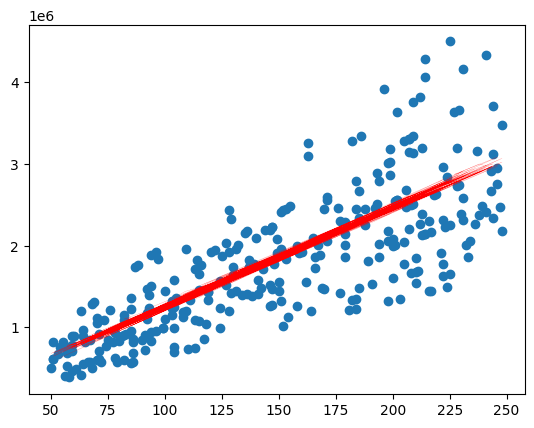

In [99]:
# Plot linear predictions
plt.scatter(X_price_test[:, 2], y_price_test)
plt.plot(X_price_test[:, 2], linear_preds, color='red', linewidth=0.1)
plt.show()

In [88]:
print(numeric_columns)

['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']


### 2.2 Logistic Regression

In [93]:
# Try just lasso first
from sklearn.linear_model import Lasso

lasso_reg = Lasso()

# Test the model on the data
lasso_reg.fit(X_price_train, y_price_train)

lasso_preds = lasso_reg.predict(X_price_test)

lasso_reg.score(X_price_test, y_price_test)

0.6104252591690443